<a href="https://colab.research.google.com/github/OrionXV/ISROProject/blob/Ishaan/plotfitterClassDocumentedISHAANFIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
#Dependencies
import astropy.convolution.convolve as conv
from astropy.convolution import Box1DKernel as box1d
from astropy.convolution import Gaussian1DKernel as g1d
from astropy.table import Table
import pandas as pd
from matplotlib.pyplot import figure
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import math 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.optimize import leastsq
from scipy.special import erf
%config InLineBackend.figure_format = 'retina'

class Curve_Fitter():
    #data_path to initialize the dataframe which we will work on. Only required parameter.
    def __init__(self, data_path, convo_size = 60):
        self.data_raw = Table.read(data_path).to_pandas()
        self.data = self.convolve(self.data_raw, convo_size) #we will use convolved data for most of our purposes

    #function to convovle the data, returns a new dataframe
    def convolve(self, data, width):
        data2 = data.copy()
        data2['RATE'] = conv(np.array(data['RATE']), kernel = g1d(width), boundary = 'extend')
        return data2
    
    #MATHS AHEAD
    #Z = (2*B + (C**2)*D)/(2*C)
    #Just a temp function so we don't have to write the expression again and again
    def z_func(self, B, C, D):
        return (2*B + (C**2)*D)/(2*C)
    
    #Our objective function, we will fit our curve over this
    def objective_func(self, T, A, B, C, D, E, F):
        return math.sqrt(np.pi*0.5)*A*C*np.exp(D/2*((2*B)+(C**2)*(D/2)-(2*(T*E+ F))))*(erf(self.z_func(B, C, D))- erf(self.z_func(B, C, D) - (T*E+ F)/C))

    #Defining the cost function. We will use sqrt(chi) for our calculations   
    def objective_cost_func(self, params, x, y):
        a0, b0, c0, d0, e0, f0 = params[0], params[1], params[2], params[3], params[4], params[5]
        return np.sqrt(((y - self.objective_func(x, a0, b0, c0, d0, e0, f0))**2)/y)

    #Sclaing functions
    def min_max_scaler(self, df):
        df['RATESCALED'] = (df['RATE']- df['RATE'].min())/(df['RATE'].max()- df['RATE'].min())
        df['TIMESCALED'] = (df['TIME']- df['TIME'].min())/(df['TIME'].max()- df['TIME'].min())*2

    def rev_scaler(self, df, x):
        return x*(df['RATE'].max()- df['RATE'].min()) + df['RATE'].min()
    
    #tolerence_func is a simple method to determine whether the range of the snippet we take for fitting does not exceed the bounds of our dataframe
    def tolerence_func(self, r, mid, start, stop):
        if mid - start < 0:
            start = 0
        else:
            start = mid - start
        if mid + stop > r:
            stop = r
        else:
            stop = mid + stop
        return start, stop
 
    #Main function, it fits the data over our objective function. Returns a list of dictionaries that tell us about the peaks and how we have fitted over them.
    #It also initializes the self.peak_df which is a data frame containing all the data for the peaks we have found
    #By default it uses the convolved data

    def peak_fitter(self, df = None, ratio = 2):
        df = self.data if df is None else df
        peak_list, _ = find_peaks(df['RATE'], height= 50) #df['RATE'].median()*
        self.min_max_scaler(df)
        #df['FIT'] = None
        peak_data_list = []
        peak_df_list = []
        width=peak_widths(df['RATE'],peak_list,rel_height=0.9)
        start=width[2].astype(int)
        stop=width[3].astype(int)
        for i in range(len(peak_list)):
            #t1 = df['RATE'][peak_list[i]]*5 #2.747; Arbitrary 
            #t2 = t1*ratio 
            #start, stop = self.tolerence_func(len(df), peak, int(t1), int(t2))
            TIME = df['TIME'][start[i]:stop[i]] - df['TIME'][start[i]] #Some scaling
            RATE = df['RATESCALED'][start[i]:stop[i]]

            params = [0.2, 0.3, 0.3, 0.4, 0.1, 0.1] #Rando params 

            resultsq = leastsq(self.objective_cost_func, params, (TIME, RATE))
            a, b, c, d, e, f = resultsq[0][0], resultsq[0][1], resultsq[0][2], resultsq[0][3], resultsq[0][4], resultsq[0][5]


            new_curve = self.objective_func(TIME, a, b, c, d, e, f)
            #Our dicc
            peak_dic = {
                'start' : start[i],
                'stop' : stop[i],
                'rate_curve' : new_curve,
                'rate_curve_scaled' : self.rev_scaler(df, new_curve),
                'curve_params' : [a, b, c, d, e, f],
                'fitted_on' : (TIME, RATE)
            }
            peak_df_list.append(pd.DataFrame.from_dict(
                {
                'start' : [start[i]],
                'stop' : [stop[i]],
                'rate_curve' : [new_curve],
                'rate_curve_scaled' : [self.rev_scaler(df, new_curve)],
                'curve_params' : [[a, b, c, d, e, f]],
                'fitted_on' : [(TIME, RATE)]
            }
            )) #For the dataframe 
            peak_data_list.append(peak_dic) #For the list

        self.peak_df = pd.concat(peak_df_list)
        self.peak_dic_list = peak_data_list
        return peak_data_list
    
    #Plots our data, if you have already called fitter, then pass the params in here. 
    def peak_data_plotter(self, df = None, peak_list = None):
        df = self.data if df is None else df
        peak_list = self.peak_fitter() if peak_list is None else peak_list
        figure(figsize=(20, 8), dpi=80)
        plt.plot(df['TIME'], df['RATE'])
        for peak in peak_list:
            plt.plot(df['TIME'][peak.get('start', 0):peak.get('stop', 0)], peak.get('rate_curve_scaled'))

In [117]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS" -O lc.zip && rm -rf /tmp/cookies.txt

--2022-03-14 15:19:36--  https://docs.google.com/uc?export=download&confirm=t&id=1bRy8RDtWz5hbOn888XHSO3QToUAYCctS
Resolving docs.google.com (docs.google.com)... 142.250.128.100, 142.250.128.139, 142.250.128.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.128.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hr1fheb7sm4jbns37bdqlfaihb7uov10/1647271125000/04989237414475792611/*/1bRy8RDtWz5hbOn888XHSO3QToUAYCctS?e=download [following]
--2022-03-14 15:19:36--  https://doc-14-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hr1fheb7sm4jbns37bdqlfaihb7uov10/1647271125000/04989237414475792611/*/1bRy8RDtWz5hbOn888XHSO3QToUAYCctS?e=download
Resolving doc-14-a0-docs.googleusercontent.com (doc-14-a0-docs.googleusercontent.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to doc-14-a0-docs.googleusercontent.com (doc-

In [53]:
!unzip -q lc.zip

replace lc/ch2_xsm_20190914_v1_level2.lc? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [126]:
file = Curve_Fitter(data_path = '/content/lc/ch2_xsm_20200410_v1_level2.lc')

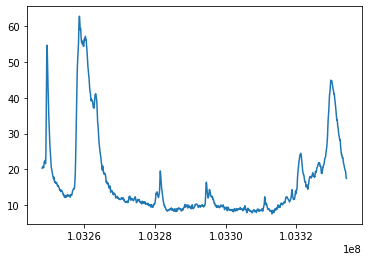

In [127]:
plt.plot(file.data['TIME'],file.data['RATE'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


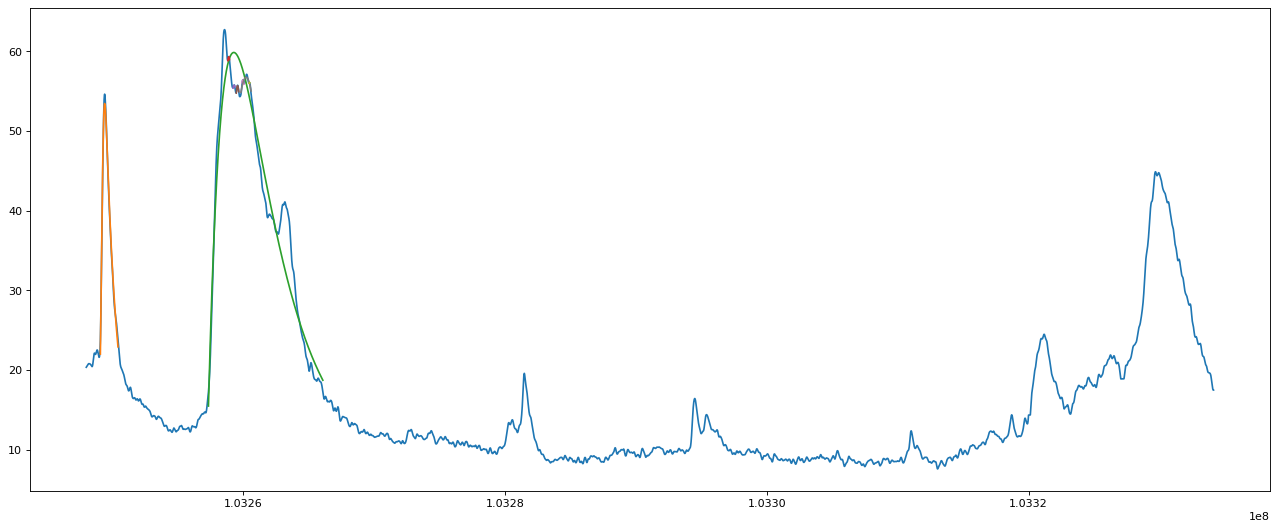

In [128]:
file.peak_data_plotter()